# Timeseries Classification on ECG data

Electrocardiography (ECG) concerns the measurement of the electrical activity of the heart. This can generally be done non-invasively using multiple electrodes placed over the skin to measure the electric potential (https://en.wikipedia.org/wiki/Electric_potential) on different specific positions, in order to capture the electrical polarization of the heart muscle over space and time. Such a heart activity is commonly expressed using a so-called QRS complex (the hearbeat core including the depolarization of right and left ventricles, and the entire contraction of the large ventricular muscles, see https://en.wikipedia.org/wiki/QRS_complex), preceded by a P wave and followed by a T wave (see picture below from Wikipedia):

![heartbeat](https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg)

In this notebook we analyze the Kaggle dataset posted at https://www.kaggle.com/shayanfazeli/heartbeat and related to the study described on https://arxiv.org/pdf/1805.00794.pdf, which uses the classic MIT-BIH Arrhythmia Dataset (classic because it is generally used as benchmark in many time series processing algorithms) and the PTB Diagnostic ECG Database (see https://www.kaggle.com/coni57/model-from-arxiv-1805-00794/data). 

In detail, the MIT-BIH consists of 360 Hz ECG data from 47 subjects, and annotated by at least 2 cardiologists using the Association  for  the  Advancementof Medical Instrumentation (AAMI) EC57 standard.
PTB (https://physionet.org/physiobank/database/ptbdb/) consists of data from 290 subjects collected using a 12 electrode unit at 1000 Hz and mapping to 52 healthy, 148 MI-ill and the rest having one of 7 differen diseases. However, the study uses only MI and healthy as target classes.

Since Kaggle requires being logged, we previously downloaded the dataset in data/ECG, as below:

In [1]:
pwd

u'/notebooks/workspace/ts-notebooks'

In [2]:
!ls data

ECG  audio


In [3]:
cd data/ECG

/notebooks/workspace/ts-notebooks/data/ECG


The dataset consists in 4 CSV files, 2 resulting from the arrythmia dataset and the other 2 from the ptbdb one.

In [4]:
ls

cnn_1.h5    lstm.h5    mitbih_test.csv   ptbdb_abnormal.csv  reference.h5
cnn_1.yaml  lstm.yaml  mitbih_train.csv  ptbdb_normal.csv    reference.yaml


Both datasets consists of ECG data at 125 Hz, though the MITBIH uses the 5 NSVFQ categories (instead of 2) and more entries than the PTBDB. The ECG signals were preprocessed and segmented, so as to have a segment for each heartbeat. The heartbeats were collected for both normal and abnormal cases, i.e., those affected by arrhythmias and myocardial infarction.

The Kaggle Kernel at https://www.kaggle.com/coni57/model-from-arxiv-1805-00794 shows how to preprocess the dataset. Let's have a quick explorative look at them:

In [5]:
%matplotlib inline
import random
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

In [6]:
initial_seed = 1234

np.random.seed(initial_seed)
random.seed(initial_seed)

In [7]:
df = pd.read_csv("mitbih_train.csv", header=None)
print "df train", len(df)
df2 = pd.read_csv("mitbih_test.csv", header=None)
print "df test", len(df2)
df = pd.concat([df, df2], axis=0)
print "df all", len(df)
df.head()

df train 87554
df test 21892
df all 109446


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


As indicated in the dataset description and also visible above, all samples were previously cropped, downsampled and padded with zeroes (where necessary) to achieve a fixed dimension of 188 samples.

In [9]:
df.values.shape

(109446, 188)

It turns out the first 0 to 186 columns describe the values, while the last one is the target category:

In [10]:
x = df.values[:,:-1]
x.shape

(109446, 187)

In [11]:
y = df.values[:,-1]
y.shape

(109446,)

In [12]:
del df2
del df

In [13]:
print y.dtype
y = y.astype(int)
print y.dtype

float64
int64


In [14]:
np.unique(y)

array([0, 1, 2, 3, 4])

Based on the preprocessing example, this maps to the heart beat categories: N (normal), S (Supraventricular premature), V (Premature ventricular contraction), F (fusion of ventricular and normal), and Q (unclassifiable).
See image at https://www.researchgate.net/profile/Pascal_Ferraro/publication/221335050/figure/tbl1/AS:668614600429573@1536421551248/Beat-classes-and-types_W640.jpg reported below:

![heartbeats](https://www.researchgate.net/profile/Pascal_Ferraro/publication/221335050/figure/tbl1/AS:668614600429573@1536421551248/Beat-classes-and-types_W640.jpg)

Let's find the indexes of each target category:

In [15]:
# np.argwhere(y == 0).shape returns (90589, 1) so flatten returns a numpy array with the indexes
C0 = np.argwhere(y == 0).flatten()
print "C0", C0.shape

C1 = np.argwhere(y == 1).flatten()
print "C1", C1.shape

C2 = np.argwhere(y == 2).flatten()
print "C2", C2.shape

C3 = np.argwhere(y == 3).flatten()
print "C3", C3.shape

C4 = np.argwhere(y == 4).flatten()
print "C4", C4.shape

C0 (90589,)
C1 (2779,)
C2 (7236,)
C3 (803,)
C4 (8039,)


Since the number of entries per class varies a lot, we will have to make sure to prevent a bias by taking the same amount of entries per class (stratification). Since the smallest class has around 800 entries we might have to augment the existing ones to create more.

In [16]:
labels = {"N":C0, "S":C1, "V":C2, "F":C3, "Q":C4}

In [17]:
for i, l in enumerate(labels):
    print i, l

0 Q
1 S
2 V
3 F
4 N


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


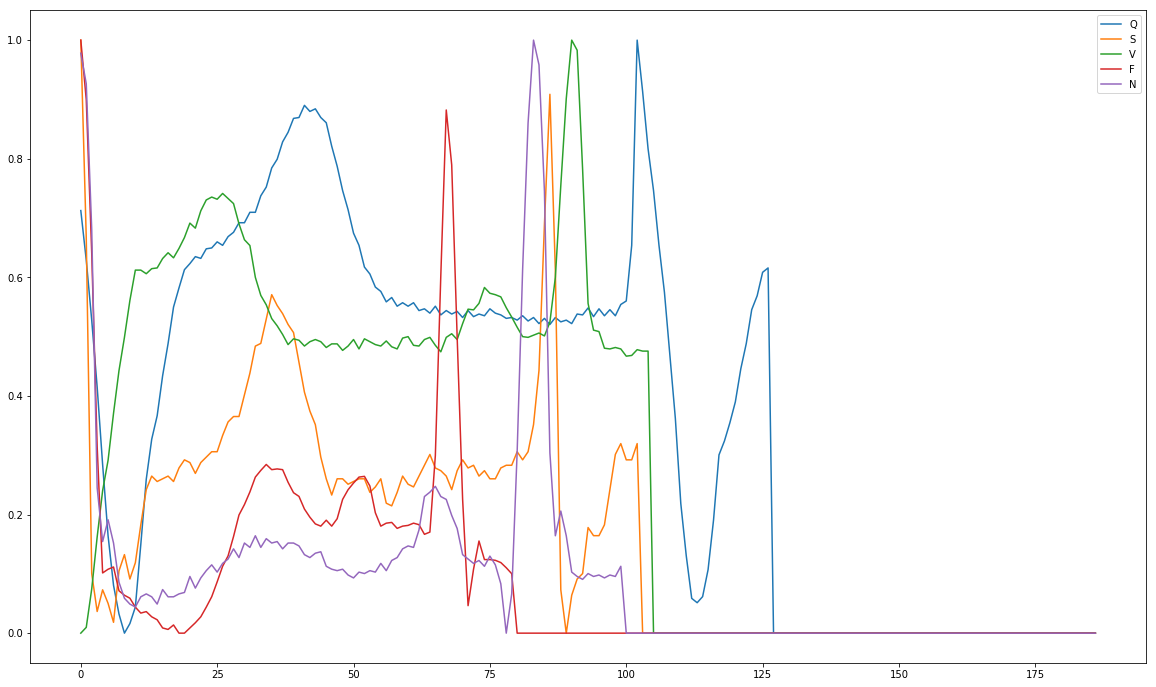

In [18]:
plt.figure(figsize=(20,12))
for i, l in enumerate(labels):
    ax = plt.subplot()
    plt.plot(np.arange(0,187), x[labels[l], :][0], label=l)
    
handles, labels2 = ax.get_legend_handles_labels()
ax.legend(handles, labels2)

In [19]:
# taken from https://www.kaggle.com/coni57/model-from-arxiv-1805-00794
import random
from scipy.signal import resample

def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

(187,)
amplified (187,)
stretched (187,)


/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


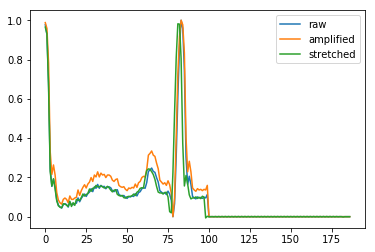

In [20]:
plt.figure()

random.seed(initial_seed)

ts=x[0, :]
print ts.shape
ax = plt.subplot()
plt.plot(ts, label="raw")

ts=amplify(x[0, :])
print "amplified", ts.shape
ax = plt.subplot()
plt.plot(ts, label="amplified")

ts=stretch(x[0, :])
print "stretched", ts.shape
ax = plt.subplot()
plt.plot(ts, label="stretched")

handles, labels2 = ax.get_legend_handles_labels()
ax.legend(handles, labels2)

In [21]:
print x[C3].shape
result = np.apply_along_axis(augment, # function to apply
                             axis=1, # axis where the array is sliced
                             arr=x[C3] # input array
                            )
print result.shape
result = result.reshape(-1, 187)
print result.shape

(803, 187)
(803, 4, 187)
(3212, 187)


/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] += X[sl]  # add the component of X at N/2


In [22]:
print result

[[ 1.          0.95856789  0.66734373 ...  0.00520577 -0.00363178
   0.00142295]
 [ 1.          0.9152245   0.68105474 ...  0.          0.
   0.        ]
 [ 1.          0.93905545  0.65871401 ... -0.00911939  0.00933271
  -0.00896832]
 ...
 [ 0.93129533  0.84191305  0.33482794 ...  0.          0.
   0.        ]
 [ 1.          0.92820353  0.56458351 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [23]:
# apply augment function
result = np.apply_along_axis(augment,
                             axis=1, 
                             arr=x[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3

# append multiple arrays
x = np.vstack([x, result])
print x.shape

y = np.hstack([y, classe])
print y.shape

(112658, 187)
(112658,)


Let's select the same amount of entries for all classes to avoid model biases:

In [24]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

Let's concatenate elements from each array together to create a train and test set:

In [25]:
x_test = np.vstack([x[subC0], x[subC1], x[subC2], x[subC3], x[subC4]])
print x_test.shape

y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])
print y_test.shape

(4000, 187)
(4000,)


In [26]:
x_train = np.delete(x,
                    [subC0, subC1, subC2, subC3, subC4],
                    axis=0)
print x_train.shape
y_train = np.delete(y,
                    [subC0, subC1, subC2, subC3, subC4],
                    axis=0)
print y_train.shape

(109145, 187)
(109145,)


In [27]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train, 
                           random_state=initial_seed)
print x_train.shape, y_train.shape
x_test, y_test = shuffle(x_test, y_test, 
                         random_state=initial_seed)
print x_test.shape, y_test.shape

(109145, 187) (109145,)
(4000, 187) (4000,)


In [28]:
del x
del y

In [29]:
x_train = np.expand_dims(x_train, 2)
print x_train.shape

x_test = np.expand_dims(x_test, 2)
print x_test.shape

(109145, 187, 1)
(4000, 187, 1)


Let's one-hot encode the 5 classes of the target variable y:

In [30]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

y_train = ohe.fit_transform(y_train.reshape(-1,1))
print y_train.shape

y_test = ohe.transform(y_test.reshape(-1,1))
print y_test.shape

(109145, 5)
(4000, 5)


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Modeling a Classifier

In this section we report the reference classifier and propose alternative ones. A classifier for time series data has as input a window of samples. The output is, in case of categorical variables encoded using one hot encoding, one output per class category. Categorical crossentropy is used as metric to train the model, along with a softmax activation function on the latest layer.

In [44]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation, Dropout, LSTM, GRU
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from livelossplot import PlotLossesKeras
from keras.regularizers import l1, l2, l1_l2

In [32]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
set_session(tf.Session(config=config))

Let's add a function to plot the training landscape and save it as a picture:

In [33]:
def plot_training_landscape(history, save_to=None):
    """
    As seen at https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    """
    # plot accuracy
    plt.figure(1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # plot loss
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    if save_to is not None:
        plt.savefig(save_to)

Let's add a function to save the model and the weights:

In [34]:
import os
from keras.models import model_from_yaml

def save_model(model, output_filename, output_path=""):
    # model structure
    model_yaml = model.to_yaml()
    yaml_path = os.path.join(output_path, output_filename+".yaml")
    with open(yaml_path, "w") as yaml_file:
        yaml_file.write(model_yaml)
    # weights
    weights_path = os.path.join(output_path, output_filename+".h5")
    model.save_weights(weights_path)
    
def load_model(filename, path=""):
    yaml_path = os.path.join(path, filename+".yaml")
    yaml_file = open(yaml_path, 'r')
    yaml_model = yaml_file.read()
    yaml_file.close()

    model = model_from_yaml(yaml_model)
    weights_path = os.path.join(path, filename+".h5")
    model.load_weights(weights_path)    
    return model

Let's reproduce the model from the Kaggle Kernel we started from and add alternatives to it, based on: LSTMs, CNN-LSTM and a ConvLSTM:

In [35]:
def model_a(window_size, depth, name="Model-Arxiv-Example"):
    """
    Model copy-pasted from https://www.kaggle.com/coni57/model-from-arxiv-1805-00794
    Model initially proposed in https://arxiv.org/pdf/1805.00794.pdf
    """
    inp = Input(shape=(window_size, depth))
    C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

    C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
    A11 = Activation("relu")(C11)
    C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
    S11 = Add()([C12, C])
    A12 = Activation("relu")(S11)
    M11 = MaxPooling1D(pool_size=5, strides=2)(A12)

    C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
    A21 = Activation("relu")(C21)
    C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
    S21 = Add()([C22, M11])
    A22 = Activation("relu")(S11)
    M21 = MaxPooling1D(pool_size=5, strides=2)(A22)

    C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
    A31 = Activation("relu")(C31)
    C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
    S31 = Add()([C32, M21])
    A32 = Activation("relu")(S31)
    M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

    C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
    A41 = Activation("relu")(C41)
    C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
    S41 = Add()([C42, M31])
    A42 = Activation("relu")(S41)
    M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

    C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
    A51 = Activation("relu")(C51)
    C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
    S51 = Add()([C52, M41])
    A52 = Activation("relu")(S51)
    M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

    F1 = Flatten()(M51)

    D1 = Dense(32)(F1)
    A6 = Activation("relu")(D1)
    D2 = Dense(32)(A6)
    D3 = Dense(5)(D2)
    A7 = Softmax()(D3)

    model = Model(inputs=inp, outputs=A7)
    
    adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

This is however just a messy copy paste which we only use as reference baseline. Let's try to investigate a bit more.

We already used LSTMs for time series prediction, we can fix the network to accomodate our categorical y variable and changing the activation function to softmax in the last layer:

In [36]:
def model_b(window_size, depth, num_categories,
            name="LSTM-Model",
            kernel_regularizer=None, bias_regularizer=None
           ):
    model = Sequential()
    model.add(LSTM(input_shape=(window_size, depth),
                   output_dim=window_size,
                   return_sequences=True
                   # https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
                  ) 
             )
    model.add(Dropout(0.5))
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    model.add(Dense(units=num_categories,
                    activation='softmax'))

    adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(loss='categorical_crossentropy',
                  #optimizer=adam,
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

def model_b_shallow(window_size, depth, num_categories, 
                    name="LSTM-Model-Shallow",
                    return_sequences=True,
                    kernel_regularizer=None, bias_regularizer=None):
    memory_units = window_size
    model = Sequential()
    model.add(LSTM(memory_units, 
                   #output_dim=memory_units,
                   input_shape=(window_size, depth),
                   return_sequences=return_sequences,
                   kernel_regularizer=kernel_regularizer,
                   bias_regularizer=bias_regularizer))
    model.add(Dropout(0.5))
    if return_sequences:
        # when using return_sequences the shape is (None, 187, 187)
        # and needs to be flattened to (None, 34969)
        # when not using return_sequences the shape is (None, 187) and we do not need that
        model.add(Flatten())
    model.add(Dense(memory_units,
                    activation='relu',
                    kernel_regularizer=kernel_regularizer,
                    bias_regularizer=bias_regularizer))
    model.add(Dropout(0.5))
    model.add(Dense(num_categories, #units=num_categories,
                    activation='softmax',
                    kernel_regularizer=kernel_regularizer,
                    bias_regularizer=bias_regularizer))

    adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(loss='categorical_crossentropy',
                  #optimizer=adam,
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

In [37]:
print model_b(x_train.shape[1], x_train.shape[2], num_categories=y_test.shape[1]).summary()
print model_b_shallow(x_train.shape[1], x_train.shape[2], num_categories=y_test.shape[1]).summary()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=187, return_sequences=True, input_shape=(187, 1))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 187, 187)          141372    
_________________________________________________________________
dropout_1 (Dropout)          (None, 187, 187)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               454656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 597,313
Trainable params: 597,313
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

We now add a network based on convolutional layers, similar to that one we used for image classification:

In [38]:
def model_c(window_size, depth, num_categories,
            name="CNN-Model",
            kernel_regularizer=None, bias_regularizer=None
           ):

    model = Sequential(name=name)
    # stage 1
    model.add(Conv1D(input_shape=(window_size, depth),
                     filters=32, # dimension of the output space
                     kernel_size=5, # length of the convolution window
                     strides=1,
                     padding="same",
                     activation="relu",
                     kernel_regularizer=kernel_regularizer,
                     bias_regularizer=bias_regularizer
                    ) 
             )
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    model.add(Dropout(0.3))
    # stage 1 output: window_size/2 x 32
    
    # stage 2
    model.add(Conv1D(filters=64, # dimension of the output space
                     kernel_size=5, # length of the convolution window
                     strides=1,
                     padding="same",
                     activation="relu",
                     kernel_regularizer=kernel_regularizer,
                     bias_regularizer=bias_regularizer
                    ) 
             )
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    model.add(Dropout(0.3))
    # stage 2 output: window_size/4 x 64
    
    # stage 3
    model.add(Conv1D(filters=128, # dimension of the output space
                     kernel_size=5, # length of the convolution window
                     strides=1,
                     padding="same",
                     activation="relu",
                     kernel_regularizer=kernel_regularizer,
                     bias_regularizer=bias_regularizer
                    ) 
             )
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    model.add(Dropout(0.3))
    # stage 3 output: window_size/8 x 64
    
    model.add(Flatten())
    # dense layers
    model.add(Dense(1024,
                    activation='relu',
                    kernel_regularizer=kernel_regularizer,
                    bias_regularizer=bias_regularizer
                   )
             )
    model.add(Dropout(0.3))
    model.add(Dense(512,
                    activation='relu',
                    kernel_regularizer=kernel_regularizer,
                    bias_regularizer=bias_regularizer
                   )
             )
    model.add(Dropout(0.3))
    
    # output layer
    model.add(Dense(units=num_categories, activation='softmax'))
    # compile
    adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(loss='categorical_crossentropy',
                  #optimizer=adam,
                  optimizer="adam",
                  metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [39]:
print model_c(x_train.shape[1], x_train.shape[2], num_categories=y_test.shape[1]).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 187, 32)           192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 94, 32)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 94, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 94, 64)            10304     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 47, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 47, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 47, 128)           41088     
__________

See the post at https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/ for a further view of time series classification in Keras, with both RNNs and CNNs mixed together. I just wanted to give a basic idea here, the possibilities to combine those 2 approaches are endless. One of the ways discussed in the post is the CNN-LSTM, consisting of the already shown Conv1D input followed by a LSTM layer and an output Dense layer using the usual softmax with categorical crossentropy. I have already used a similar architecture in the imdb sentiment analysis example, also available on the ufficial Keras repo (https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py):

In [40]:
def model_d(window_size, depth, num_categories,
            name="CNN-LSTM-Model",
            num_cnn_stages=2,
            return_sequences=True,
            kernel_regularizer=None, bias_regularizer=None
           ):
    
    model = Sequential(name=name)
    cnn_dimension = 32
    # stage 1 - CNN
    model.add(Conv1D(input_shape=(window_size, depth),
                     filters=cnn_dimension, # dimension of the output space
                     kernel_size=5, # length of the convolution window
                     strides=1,
                     padding="same",
                     activation="relu",
                     kernel_regularizer=kernel_regularizer,
                     bias_regularizer=bias_regularizer
                    ) 
             )
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    model.add(Dropout(0.3))
    
    # stage 1 output: window_size/2 x 32
    for s in range(1, num_cnn_stages):
        cnn_dimension = cnn_dimension * 2
        # stage 2 - CNN
        model.add(Conv1D(filters=cnn_dimension, # dimension of the output space doubled each stage
                         kernel_size=5, # length of the convolution window
                         strides=1,
                         padding="same",
                         activation="relu",
                         kernel_regularizer=kernel_regularizer,
                         bias_regularizer=bias_regularizer))
        model.add(MaxPooling1D(pool_size=2, padding="same"))
        model.add(Dropout(0.3))
        # stage 2 output: window_size/(2*2s) x 64
    
    # stage 2 - LSTM
    memory_units = window_size # it's a lot but let's keep it the same as we did above
    model.add(LSTM(memory_units, 
                   #output_dim=memory_units,
                   input_shape=(window_size, depth),
                   return_sequences=return_sequences,
                   kernel_regularizer=kernel_regularizer,
                   bias_regularizer=bias_regularizer))
    if return_sequences:
        model.add(Flatten())
    
    # stage 3 - Dense output layer
    model.add(Dense(units=num_categories, activation='softmax'))
    # compile
    adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

The post goes on by showcasing the ConvLSTM2D, which should have a more limited search space to the one just used, by allowing for a better integration of the convolution layer into the recurrent LSTM layer that follows. I will leave this out of this notebook, feel free to have a look here (https://keras.io/layers/recurrent/#convlstm2d).

I want to try the difference when using a gate-recurrent unit (GRU).

In [41]:
def model_e(window_size, depth, num_categories,
            name="GRU-Model",
            kernel_regularizer=None, bias_regularizer=None
           ):
    """
    This model is the same like model_b, just using a GRU instead of an LSTM
    """
    model = Sequential()
    model.add(GRU(input_shape=(window_size, depth),
                   output_dim=window_size,
                   return_sequences=True
                   # https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
                  ) 
             )
    model.add(Dropout(0.5))
    model.add(GRU(256))
    model.add(Dropout(0.5))
    model.add(Dense(units=num_categories,
                    activation='softmax'))

    adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(loss='categorical_crossentropy',
                  #optimizer=adam,
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

## Training Settings

In [42]:
n_obs, window_size, depth = x_train.shape
print n_obs, window_size, depth
batch_size = 500
epochs = 75

109145 187 1


For simplicity I will be using the livelossplot python library to have real time plotting of the accuracy.

## Reference Model

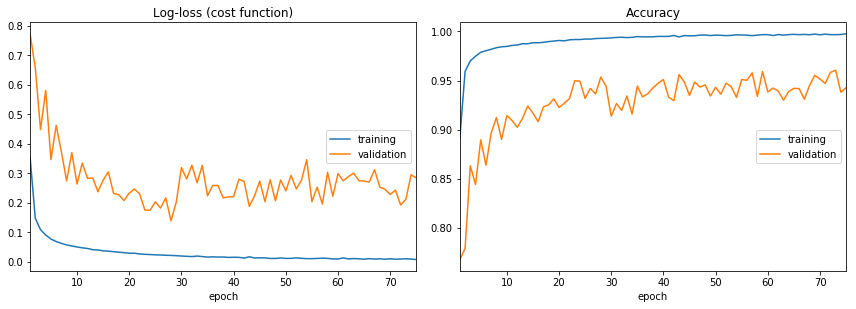

In [74]:
import math
def exp_decay(epoch):
    """
        Learning  rate  is  decayed  exponentially  with  the decay  factor  of 0.75 every 10000 iterations. 
    """
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate


model = model_a(window_size, depth)
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras(),
                               LearningRateScheduler(exp_decay)
                              ]
                   )

In [75]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.27%


In [76]:
save_model(model, "reference", output_path="")

In [77]:
!ls

lstm.h5    mitbih_test.csv   ptbdb_abnormal.csv  reference.h5
lstm.yaml  mitbih_train.csv  ptbdb_normal.csv	 reference.yaml


## LSTM-based Classifier

### 2-Layered LSTM

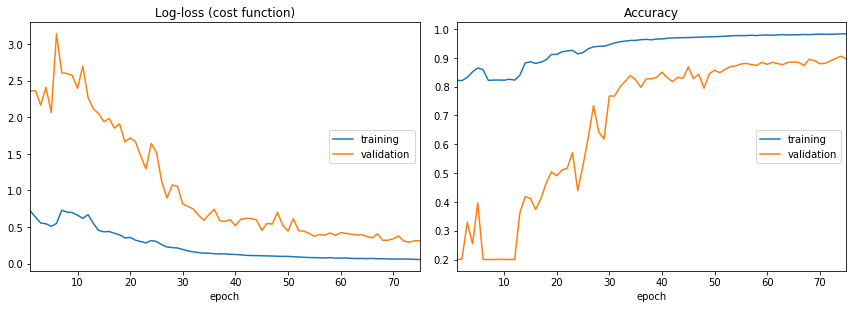

In [63]:
model = model_b(window_size, depth, num_categories=y_test.shape[1])
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [64]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 89.68%


In [69]:
save_model(model, "lstm", output_path="")

In [70]:
!ls

lstm.h5    mitbih_test.csv   ptbdb_abnormal.csv
lstm.yaml  mitbih_train.csv  ptbdb_normal.csv


### Shallow LSTM

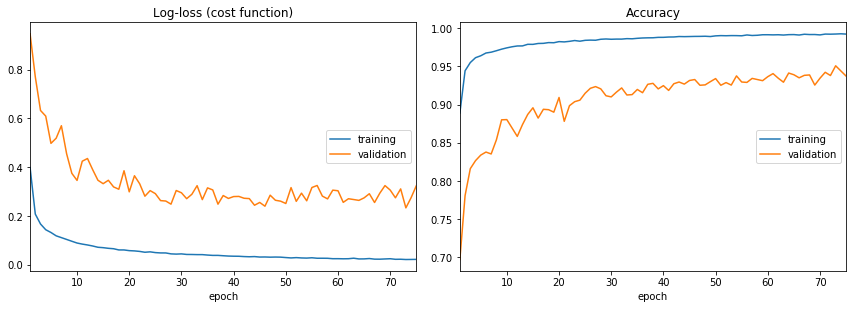

In [150]:
model = model_b_shallow(window_size, depth, num_categories=y_test.shape[1])
print model.summary()

history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [151]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 93.73%


In [ ]:
save_model(model, "lstm_shallow", output_path="")
!ls

### 2-Layered LSTM with Regularization

#### L1 Regularization

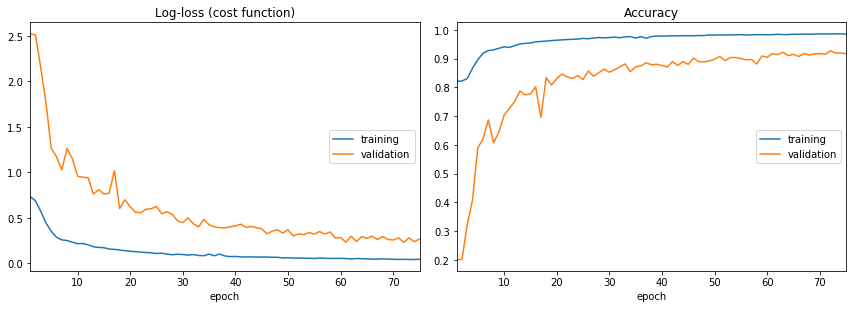

In [152]:
model = model_b(window_size, depth, num_categories=y_test.shape[1],
                kernel_regularizer=l1(0.00005),
                bias_regularizer=l1(0.00005))
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [153]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.72%


#### L2 Regularization

In [ ]:
model = model_b(window_size, depth, num_categories=y_test.shape[1],
                kernel_regularizer=l2(0.00005),
                bias_regularizer=l2(0.00005))
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

## CNN-based Classifier

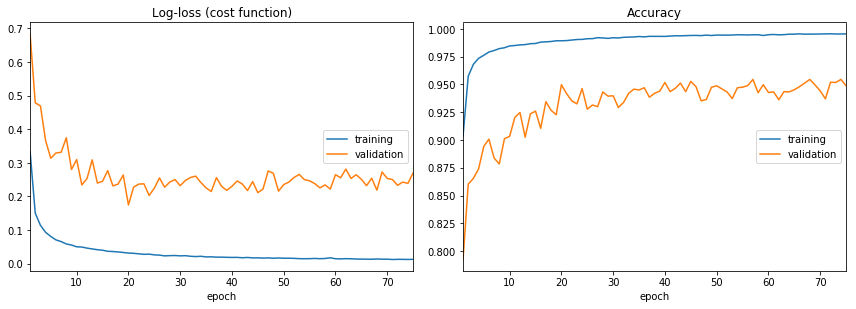

In [81]:
model = model_c(window_size, depth, num_categories=y_test.shape[1])
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [82]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.88%


In [83]:
save_model(model, "cnn_1", output_path="")

In [84]:
!ls

cnn_1.h5    lstm.h5    mitbih_test.csv	 ptbdb_abnormal.csv  reference.h5
cnn_1.yaml  lstm.yaml  mitbih_train.csv  ptbdb_normal.csv    reference.yaml


## CNN-based Classifier with regularization

We now try to add weight regularization, which beside the already existing drop out should reduce model overfitting and improve the validation accuracy. 
In Keras (https://keras.io/regularizers/) there exists the following regularizers:
* L1: Sum of the absolute weights
* L2: Sum of the squared weights
* L1L2: Sum of the absolute and the squared weights

### L1 Regularization

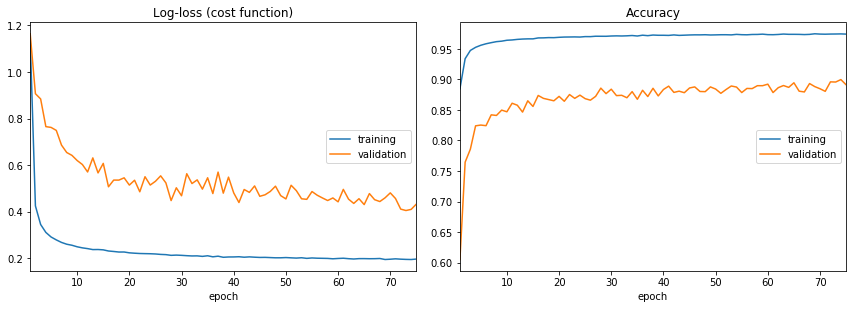

In [90]:
model = model_c(window_size, depth, num_categories=y_test.shape[1],
                kernel_regularizer=l1(0.00005),
                bias_regularizer=None #l1(0.00005)
                 )
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [ ]:
#scores = model.evaluate(x_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#save_model(model, "cnn_1_l1_regularized", output_path="")

In [ ]:
!ls

### L2 Regularization

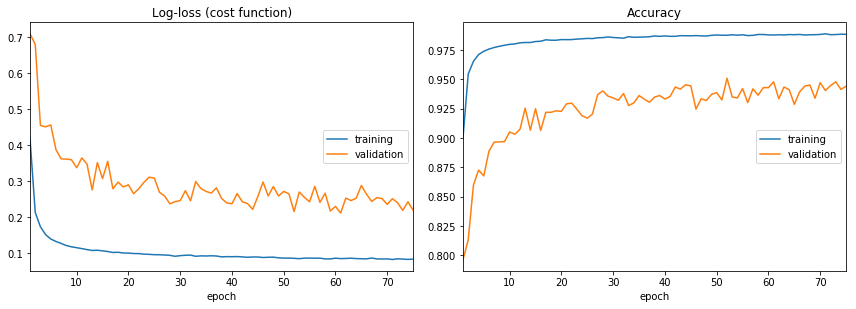

In [91]:
model = model_c(window_size, depth, num_categories=y_test.shape[1],
                kernel_regularizer=l2(0.00005),
                bias_regularizer=l2(0.00005)
               )
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [ ]:
#scores = model.evaluate(x_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#save_model(model, "cnn_1_l2_regularized", output_path="")

In [ ]:
!ls

### L1L2 Regularization

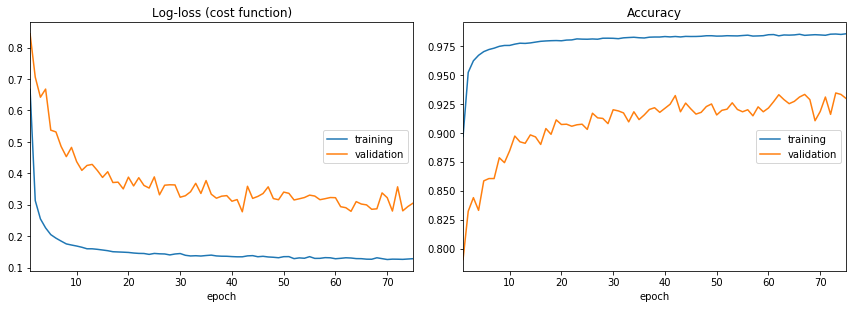

In [94]:
model = model_c(window_size, depth, num_categories=y_test.shape[1],
                kernel_regularizer=l1_l2(l1=0.00001, l2=0.00001),
                bias_regularizer=l1_l2(l1=0.00001, l2=0.00001)
                 )
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [95]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 92.97%


In [ ]:
#save_model(model, "cnn_1_l1l2_regularized", output_path="")

In [ ]:
!ls

## CNN-LSTM Classifier

### Without Regularization

#### 2-layers CNN

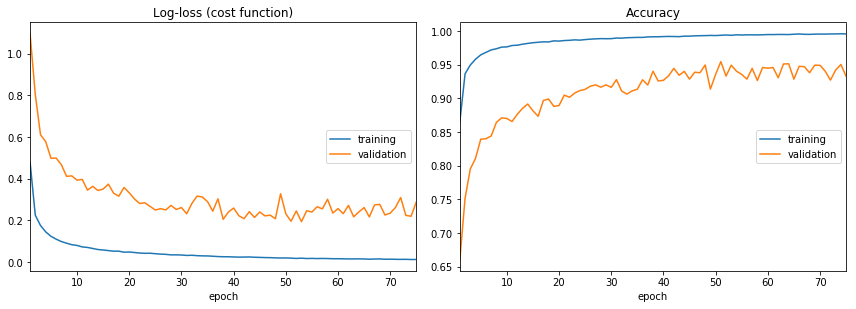

In [87]:
model = model_d(window_size, depth, 
                return_sequences=True, num_cnn_stages=2,
                num_categories=y_test.shape[1])
print model.summary()
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [89]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 93.27%


#### 1-layer CNN

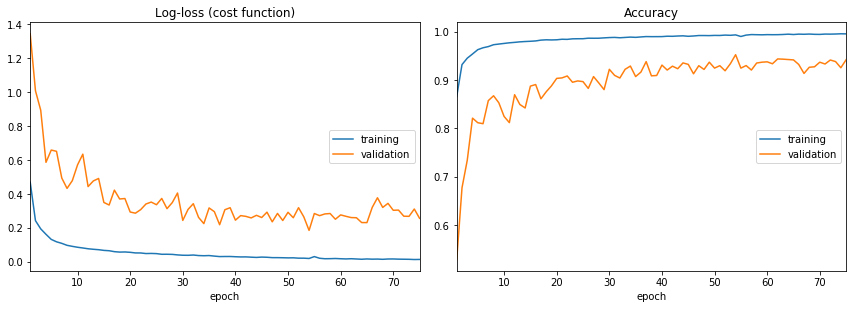

In [90]:
model = model_d(window_size, depth, 
                return_sequences=True, num_cnn_stages=1,
                num_categories=y_test.shape[1])
print model.summary()
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

In [91]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.17%


## GRU-based classifier

### 2-layer GRU without regularization

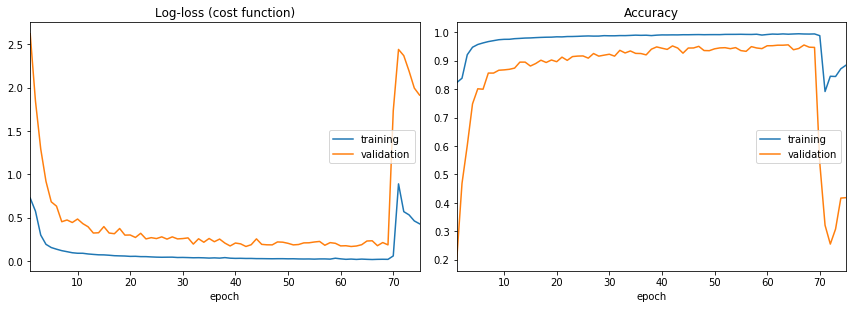

Log-loss (cost function):
training   (min:    0.017, max:    0.889, cur:    0.429)
validation (min:    0.167, max:    2.620, cur:    1.913)

Accuracy:
training   (min:    0.791, max:    0.994, cur:    0.884)
validation (min:    0.201, max:    0.955, cur:    0.418)


In [45]:
model = model_e(window_size, depth, num_categories=y_test.shape[1])
print model.summary()
history = model.fit(x_train,
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(x_test, y_test), 
                    callbacks=[PlotLossesKeras()])

This should tell you when to stop.